# Exercise 3.1
### Generation of MNIST digits with a GAN

First we import the modules we need

In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

Implement your **generator** network as a fully connected neural network

Start out with a network that:
* takes as input 100 Normally distributed numbers
* has four hidden layers with 4096 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [39]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        n_features = 100
        n_out = 28 * 28
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4096),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU()
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(4096, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has Sigmoid as the last layer (we work with MNIST in the 0 to 1 range)

In [40]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()   
        self.hidden0 = nn.Sequential(
            nn.Linear(28 * 28, 4096),
            nn.LeakyReLU(.2),
            nn.Dropout()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.LeakyReLU(.2),
            nn.Dropout()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(.2),
            nn.Dropout()
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(.2),
            nn.Dropout()
        )
        self.out = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

In [58]:
def d_loss_vanilla(x, z):
    loss = -(torch.log(x).mean() + torch.log(1-z).mean())
    return loss

In [59]:
def d_loss_lsgan(x,z):
    loss = .5 * torch.mean((x - 1) ** 2) + .5 * torch.mean(z ** 2)
    return loss

In [60]:
def g_loss_vanilla(z):
    loss = torch.log(1 - z).mean()
    return loss

In [61]:
def g_loss_lsgan(z):
    loss = .5 * torch.mean((z - 1) ** 2)
    return loss

Output()

RuntimeError: DataLoader worker (pid(s) 18873) exited unexpectedly

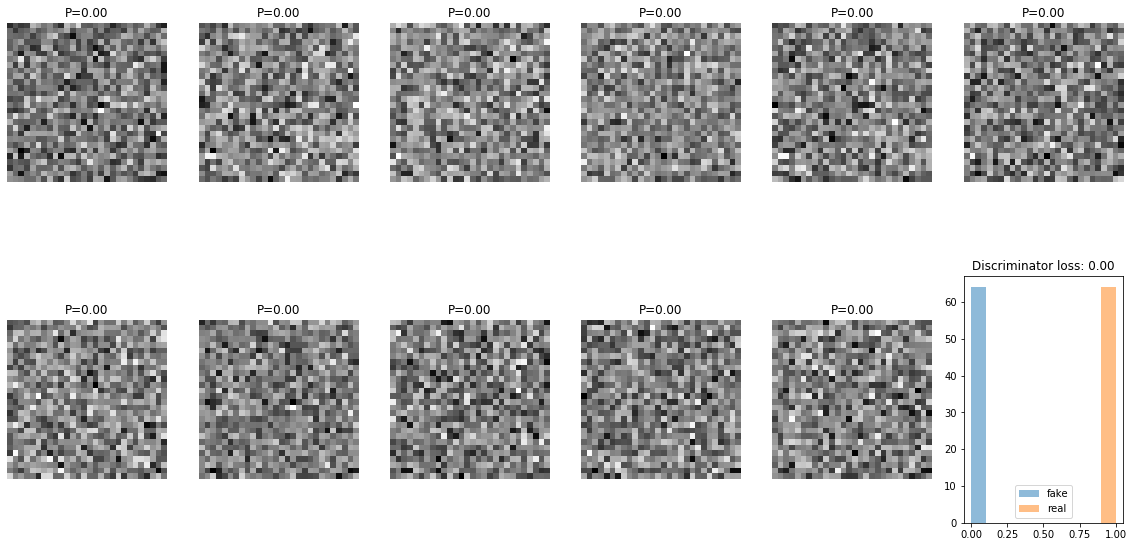

In [65]:
#Initialize networks
d = D().to(device)
g = G().to(device)
#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100).to(device) # generating noise
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z)

        d_loss = d_loss_vanilla(d(x), d(xhat))
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 100).cuda()
        g.zero_grad()
        
        g_loss = g_loss_vanilla(d(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = d(xhat)
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d(g(torch.randn(batch_size, 100).to(device)))
                H2 = d(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

In [ ]:
# saving models
torch.save(d.state_dict(), "d.pth")
torch.save(g.state_dict(), "g.pth")

<h2> DCGAN</h2>

In [49]:
class D_DCGAN(nn.Module):
    def __init__(self):
        super(D_DCGAN, self).__init__()
        
        # state size: 1 * 28 * 28
        self.hidden0 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(.2, inplace=True),
        )
        # state size: 128 * 14 * 14
        self.hidden1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2, inplace=True),
        )
        # state size: 256 * 7 * 7
        self.hidden2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(.2, inplace=True),
        )
        # state size: 512 * 1 * 1
        self.out = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [50]:
class G_DCGAN(nn.Module):
    def __init__(self):
        super(G_DCGAN, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size=3, stride=2), 
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        # sate size: 1024 * 3 * 3
        self.hidden1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        # sate size: 512 * 7 * 7
        self.hidden2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # sate size: 256 * 14 * 14
        self.hidden3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        # sate size: 128 * 28 * 28
        self.out = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) # reshape
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

Output()

KeyboardInterrupt: 

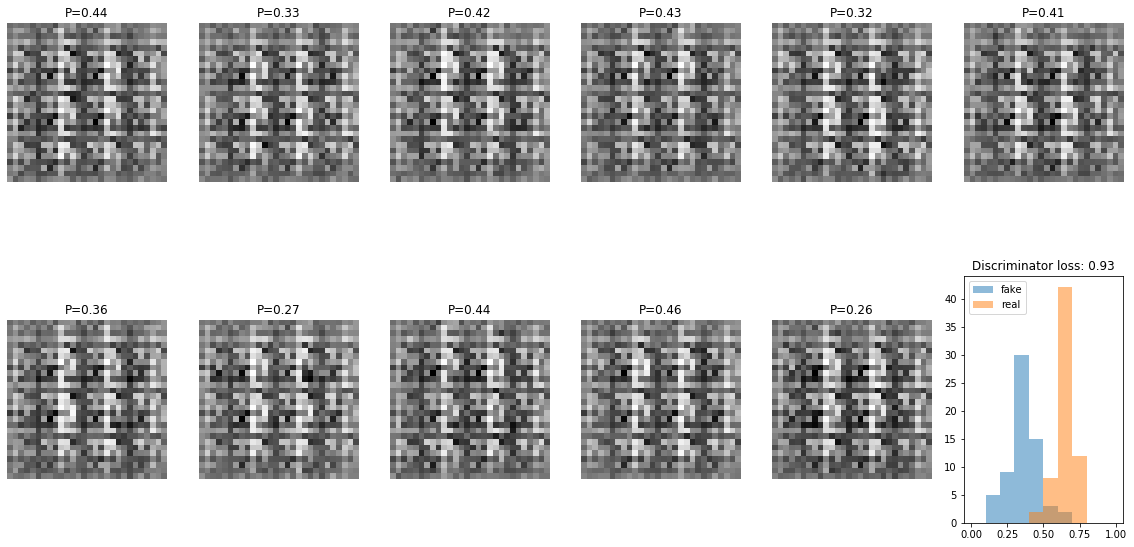

In [64]:
#Initialize networks
d_cgan = D_DCGAN().to(device)
g_cgan = G_DCGAN().to(device)
#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d_cgan.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_cgan.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100).to(device) # generating noise
        d_cgan.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g_cgan(z)

        d_loss = d_loss_vanilla(d_cgan(x), d_cgan(xhat))
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 100).cuda()
        g_cgan.zero_grad()
        xhat = g_cgan(z)
        g_loss = g_loss_vanilla(d_cgan(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = d_cgan(xhat)
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d_cgan(g_cgan(torch.randn(batch_size, 100).to(device)))
                H2 = d_cgan(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

In [53]:
# saving models
torch.save(d_cgan.state_dict(), "d_dcgan.pth")
torch.save(g_cgan.state_dict(), "g_dcgan.pth")

Did you get a model to generate nice images?
Consider these
# Additional tasks
* Implement another loss
* Convert your network to a DCGAN
* Generate images from FashionMNIST
* Convert your architecture into a cGAN
* Hard: Create a cGAN model to convert from SVHN to MNIST

In [56]:
d_loss_ == d_loss_vanilla

False

In [57]:
d_loss_vanilla

<function __main__.d_loss_vanilla(x, z)>